# Herschel Stripe 82 master catalogue

This notebook presents the merge of the various pristine catalogues to produce HELP mater catalogue on Herschel Stripe 82.

In [1]:
from herschelhelp_internal import git_version
print("This notebook was run with herschelhelp_internal version: \n{}".format(git_version()))

This notebook was run with herschelhelp_internal version: 
33f5ec7 (Wed Dec 6 16:56:17 2017 +0000) [with local modifications]


In [1]:
%matplotlib inline
#%config InlineBackend.figure_format = 'svg'

import matplotlib.pyplot as plt
plt.rc('figure', figsize=(10, 6))

import os
import time

from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.table import Column, Table, join
import numpy as np
from pymoc import MOC

from herschelhelp_internal.masterlist import merge_catalogues, nb_merge_dist_plot
from herschelhelp_internal.utils import coords_to_hpidx, ebv, gen_help_id, inMoc

/Users/rs548/anaconda/envs/herschelhelp_internal/lib/python3.6/site-packages/seaborn/apionly.py:6: UserWarning: As seaborn no longer sets a default style on import, the seaborn.apionly module is deprecated. It will be removed in a future version.
  warnings.warn(msg, UserWarning)


In [3]:
TMP_DIR = os.environ.get('TMP_DIR', "./data_tmp")

SUFFIX = os.environ.get('SUFFIX', time.strftime("_%Y%m%d"))
OUT_DIR = os.environ.get('OUT_DIR', "./data")

try:
    os.makedirs(OUT_DIR)
except FileExistsError:
    pass

## I - Reading the prepared pristine catalogues

In [4]:
hsc =    Table.read("{}/HSC-SSP.fits".format(TMP_DIR)   )["hsc_id",      "hsc_ra",    "hsc_dec",
                                                          "hsc_flag_gaia"]
vhs =    Table.read("{}/VISTA-VHS.fits".format(TMP_DIR) )["vhs_id",      "vhs_ra",    "vhs_dec",    
                                                          "vhs_stellarity", "vhs_flag_gaia"]
vics82 = Table.read("{}/VICS82.fits".format(TMP_DIR)    )["vics82_id",   "vics82_ra", "vics82_dec", 
                                                          "vics82_stellarity", "vics82_flag_gaia"]
las =    Table.read("{}/UKIDSS-LAS.fits".format(TMP_DIR))["las_id",      "las_ra",    "las_dec",    
                                                          "las_stellarity", "las_flag_gaia"]
ps1 =    Table.read("{}/PS1.fits".format(TMP_DIR)       )["ps1_id",      "ps1_ra",    "ps1_dec",
                                                         "ps1_flag_gaia"]
#shela =  Table.read("{}/SHELA.fits".format(TMP_DIR)     )["shela_intid", "shela_ra",  "shela_dec"]
#spies =  Table.read("{}/SpIES.fits".format(TMP_DIR)     )["spies_intid", "spies_ra",  "spies_dec",  "spies_stellarity_irac2"]
irac =   Table.read("{}/irac_merged_catalogue_herschel-stripe-82.fits".format(TMP_DIR)      )[
                                                          "irac_intid",  "irac_ra",   "irac_dec",   
                                                          "irac_stellarity", "irac_flag_gaia",
                                                         "shela_intid", "spies_intid"]
#decals = Table.read("{}/DECaLS.fits".format(TMP_DIR)    )["decals_id",   "decals_ra", "decals_dec", 
#                                                          "decals_stellarity", "decals_flag_gaia"]
decam = Table.read("{}/decam_merged_catalogue_herschel-stripe-82.fits".format(TMP_DIR)    )[
                                                          "decam_intid", "des_id", "decals_id",   
                                                          "decam_ra", "decam_dec", 
                                                          "decam_stellarity", "decam_flag_gaia"]
rcs =    Table.read("{}/RCSLenS.fits".format(TMP_DIR)   )["rcs_id",      "rcs_ra",    "rcs_dec",    
                                                          "rcs_stellarity", "rcs_flag_gaia"]
#We choose to use the IAC version not SDSS-S82.fits
sdss =   Table.read("{}/SDSS-S82_IAC.fits".format(TMP_DIR)  )["sdss_id",     "sdss_ra",   "sdss_dec",   
                                                          "sdss_stellarity", "sdss_flag_gaia"]

## II - Merging tables

We first merge the optical catalogues and then add the infrared ones: HSC, VHS, VICS82, UKIDSS-LAS, PanSTARRS, SHELA, SpIES.

At every step, we look at the distribution of the distances to the nearest source in the merged catalogue to determine the best crossmatching radius.

### HSC

In [5]:
master_catalogue = hsc
master_catalogue['hsc_ra'].name = 'ra'
master_catalogue['hsc_dec'].name = 'dec'
del hsc

### Add VHS

In [6]:
nb_merge_dist_plot(
    SkyCoord(master_catalogue['ra'], master_catalogue['dec']),
    SkyCoord(vhs['vhs_ra'], vhs['vhs_dec'])
)

HELP Warning: There weren't any cross matches. The two surveys probably don't overlap.


In [7]:
# Given the graph above, we use 0.8 arc-second radius
master_catalogue = merge_catalogues(master_catalogue, vhs, "vhs_ra", "vhs_dec", radius=0.8*u.arcsec)
del vhs

### Add VICS82

In [8]:
nb_merge_dist_plot(
    SkyCoord(master_catalogue['ra'], master_catalogue['dec']),
    SkyCoord(vics82['vics82_ra'], vics82['vics82_dec'])
)

HELP Warning: There weren't any cross matches. The two surveys probably don't overlap.


In [9]:
# Given the graph above, we use 0.8 arc-second radius
master_catalogue = merge_catalogues(master_catalogue, vics82, "vics82_ra", "vics82_dec", radius=0.8*u.arcsec)
del vics82

### Add LAS

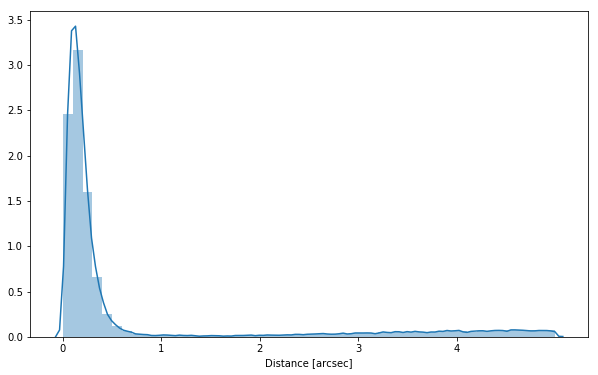

In [10]:
nb_merge_dist_plot(
    SkyCoord(master_catalogue['ra'], master_catalogue['dec']),
    SkyCoord(las['las_ra'], las['las_dec'])
)

In [11]:
# Given the graph above, we use 0.8 arc-second radius
master_catalogue = merge_catalogues(master_catalogue, las, "las_ra", "las_dec", radius=0.8*u.arcsec)
del las

### Add PanSTARRS

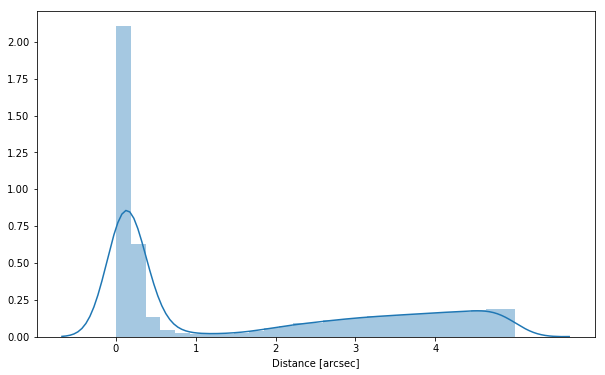

In [12]:
nb_merge_dist_plot(
    SkyCoord(master_catalogue['ra'], master_catalogue['dec']),
    SkyCoord(ps1['ps1_ra'], ps1['ps1_dec'])
)

In [13]:
# Given the graph above, we use 0.8 arc-second radius
master_catalogue = merge_catalogues(master_catalogue, ps1, "ps1_ra", "ps1_dec", radius=0.8*u.arcsec)
del ps1

## Add SDSS
We are waiting for a new SDSS-82 catalogue, which does not suffer from the issue of multiple sources per object due to including all exposure extractions.

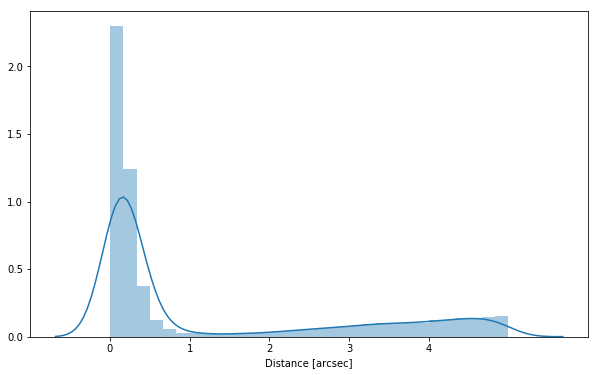

In [14]:
nb_merge_dist_plot(
    SkyCoord(master_catalogue['ra'], master_catalogue['dec']),
    SkyCoord(sdss['sdss_ra'], sdss['sdss_dec'])
)

In [15]:
# Given the graph above, we use 0.8 arc-second radius
master_catalogue = merge_catalogues(master_catalogue, sdss, "sdss_ra", "sdss_dec", radius=0.8*u.arcsec)
del sdss

## Add DECam (DECaLS and DES)

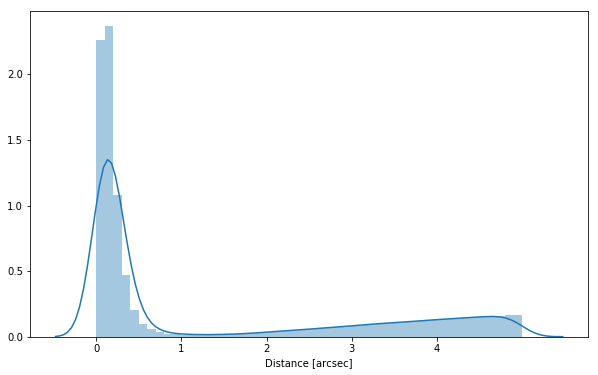

In [16]:
nb_merge_dist_plot(
    SkyCoord(master_catalogue['ra'], master_catalogue['dec']),
    SkyCoord(decam['decam_ra'], decam['decam_dec'])
)

In [17]:
# Given the graph above, we use 0.8 arc-second radius
master_catalogue = merge_catalogues(master_catalogue, decam, "decam_ra", "decam_dec", radius=0.8*u.arcsec)
del decam

## Add RCSLenS

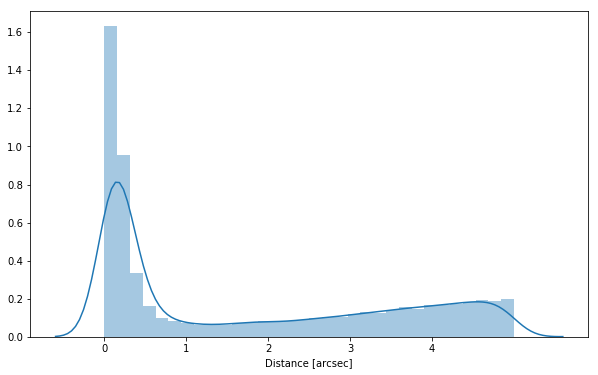

In [18]:
nb_merge_dist_plot(
    SkyCoord(master_catalogue['ra'], master_catalogue['dec']),
    SkyCoord(rcs['rcs_ra'], rcs['rcs_dec'])
)

In [19]:
# Given the graph above, we use 0.8 arc-second radius
master_catalogue = merge_catalogues(master_catalogue, rcs, "rcs_ra", "rcs_dec", radius=0.8*u.arcsec)
del rcs

## Add IRAC (SHELA and SpIES)

In [20]:
nb_merge_dist_plot(
    SkyCoord(master_catalogue['ra'], master_catalogue['dec']),
    SkyCoord(irac['irac_ra'], irac['irac_dec'])
)

HELP Warning: There weren't any cross matches. The two surveys probably don't overlap.


In [21]:
# Given the graph above, we use 1 arc-second radius
master_catalogue = merge_catalogues(master_catalogue, irac, "irac_ra", "irac_dec", radius=1.5*u.arcsec)
del irac

### Cleaning

When we merge the catalogues, astropy masks the non-existent values (e.g. when a row comes only from a catalogue and has no counterparts in the other, the columns from the latest are masked for that row). We indicate to use NaN for masked values for floats columns, False for flag columns and -1 for ID columns.

In [24]:
for col in master_catalogue.colnames:
    if (col.startswith("m_") or col.startswith("merr_") or col.startswith("f_") or col.startswith("ferr_")):
        master_catalogue[col] = master_catalogue[col].astype(float)
        master_catalogue[col].fill_value = np.nan
    if "stellarity" in col:
        master_catalogue[col].fill_value = np.nan
    elif "flag" in col:
        master_catalogue[col].fill_value = 0
    elif "id" in col:
        master_catalogue[col].fill_value = -1
        
master_catalogue = master_catalogue.filled()

In [25]:
master_catalogue[:10].show_in_notebook()

idx,hsc_id,ra,dec,hsc_flag_gaia,flag_merged,vhs_id,vhs_stellarity,vhs_flag_gaia,vics82_id,vics82_stellarity,vics82_flag_gaia,las_id,las_stellarity,las_flag_gaia,ps1_id,ps1_flag_gaia,sdss_id,sdss_stellarity,sdss_flag_gaia,decam_intid,des_id,decals_id,decam_stellarity,decam_flag_gaia,rcs_id,rcs_stellarity,rcs_flag_gaia,irac_intid,irac_stellarity,irac_flag_gaia,shela_intid,spies_intid
,,deg,deg,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,42697064458515903,353.750052436,0.188432480658,3,False,-1,nan,0,-1,nan,0,-1,nan,0,-1,0,-1,nan,0,-1,-1,-1,nan,0,-1,nan,0,-1,nan,0,-1,-1
1,42697064458508303,353.65256585,0.11614505011,0,False,-1,nan,0,-1,nan,0,-1,nan,0,-1,0,-1,nan,0,-1,-1,-1,nan,0,-1,nan,0,-1,nan,0,-1,-1
2,42697060163548288,353.676114547,0.0526360491363,0,False,-1,nan,0,-1,nan,0,-1,nan,0,-1,0,-1,nan,0,-1,-1,-1,nan,0,-1,nan,0,-1,nan,0,-1,-1
3,42697068753489548,353.643185102,0.459447199211,0,False,-1,nan,0,-1,nan,0,-1,nan,0,-1,0,-1,nan,0,-1,-1,-1,nan,0,-1,nan,0,-1,nan,0,-1,-1
4,42697073048455227,353.68947459,0.621285619561,0,False,-1,nan,0,-1,nan,0,-1,nan,0,-1,0,-1,nan,0,-1,-1,-1,nan,0,-1,nan,0,-1,nan,0,-1,-1
5,42697210487404068,353.516284125,0.53220784816,3,True,-1,nan,0,-1,nan,0,-1,nan,0,-1,0,-1,nan,0,-1,-1,-1,nan,0,-1,nan,0,-1,nan,0,-1,-1
6,42697068753484122,353.651263865,0.388484663025,0,False,-1,nan,0,-1,nan,0,-1,nan,0,-1,0,-1,nan,0,-1,-1,-1,nan,0,-1,nan,0,-1,nan,0,-1,-1
7,42696922724569878,353.923288143,0.0796050602125,0,False,-1,nan,0,-1,nan,0,-1,nan,0,-1,0,-1,nan,0,-1,-1,-1,nan,0,-1,nan,0,-1,nan,0,-1,-1
8,42697197602501563,353.517178604,0.0166990365285,0,False,-1,nan,0,-1,nan,0,-1,nan,0,-1,0,-1,nan,0,-1,-1,-1,nan,0,-1,nan,0,-1,nan,0,-1,-1


## III - Merging flags and stellarity

Each pristine catalogue contains a flag indicating if the source was associated to a another nearby source that was removed during the cleaning process.  We merge these flags in a single one.

In [26]:
flag_cleaned_columns = [column for column in master_catalogue.colnames
                        if 'flag_cleaned' in column]

flag_column = np.zeros(len(master_catalogue), dtype=bool)
for column in flag_cleaned_columns:
    flag_column |= master_catalogue[column]
    
master_catalogue.add_column(Column(data=flag_column, name="flag_cleaned"))
master_catalogue.remove_columns(flag_cleaned_columns)

Each pristine catalogue contains a flag indicating the probability of a source being a Gaia object (0: not a Gaia object, 1: possibly, 2: probably, 3: definitely).  We merge these flags taking the highest value.

In [27]:
flag_gaia_columns = [column for column in master_catalogue.colnames
                     if 'flag_gaia' in column]

master_catalogue.add_column(Column(
    data=np.max([master_catalogue[column] for column in flag_gaia_columns], axis=0),
    name="flag_gaia"
))
master_catalogue.remove_columns(flag_gaia_columns)

Each prisitine catalogue may contain one or several stellarity columns indicating the probability (0 to 1) of each source being a star.  We merge these columns taking the highest value.

In [28]:
stellarity_columns = [column for column in master_catalogue.colnames
                      if 'stellarity' in column]

print(", ".join(stellarity_columns))

/Users/rs548/anaconda/envs/herschelhelp_internal/lib/python3.6/site-packages/ipykernel/__main__.py:5: RuntimeWarning: All-NaN axis encountered


In [ ]:

# We create an masked array with all the stellarities and get the maximum value, as well as its
# origin.  Some sources may not have an associated stellarity.
stellarity_array = np.array([master_catalogue[column] for column in stellarity_columns])
stellarity_array = np.ma.masked_array(stellarity_array, np.isnan(stellarity_array))

max_stellarity = np.max(stellarity_array, axis=0)
max_stellarity.fill_value = np.nan

no_stellarity_mask = max_stellarity.mask

master_catalogue.add_column(Column(data=max_stellarity.filled(), name="stellarity"))

stellarity_origin = np.full(len(master_catalogue), "NO_INFORMATION", dtype="S20")
stellarity_origin[~no_stellarity_mask] = np.array(stellarity_columns)[np.argmax(stellarity_array, axis=0)[~no_stellarity_mask]]

master_catalogue.add_column(Column(data=stellarity_origin, name="stellarity_origin"))

master_catalogue.remove_columns(stellarity_columns)

## IV - Adding E(B-V) column

In [29]:
master_catalogue.add_column(
    ebv(master_catalogue['ra'], master_catalogue['dec'])
)

## V - Adding HELP unique identifiers and field columns

In [30]:
master_catalogue.add_column(Column(gen_help_id(master_catalogue['ra'], master_catalogue['dec']),
                                   name="help_id"))
master_catalogue.add_column(Column(np.full(len(master_catalogue), "Herschel-Stripe-82", dtype='<U18'),
                                   name="field"))

In [31]:
# Check that the HELP Ids are unique
if len(master_catalogue) != len(np.unique(master_catalogue['help_id'])):
    print("The HELP IDs are not unique!!!")
else:
    print("OK!")

OK!


## VI - Adding spec-z

In [2]:
specz =  Table.read("../../dmu23/dmu23_Herschel-Stripe-82/data/HELP-SPECZ_Herschel-Stripe-82_20170202.fits")

In [3]:
nb_merge_dist_plot(
    SkyCoord(master_catalogue['ra'], master_catalogue['dec']),
    SkyCoord(specz['ra'] * u.deg, specz['dec'] * u.deg)
)

['field',
 'specz_id',
 'ra',
 'dec',
 'z_spec',
 'z_source',
 'z_qual',
 'z_rel',
 'agn_flag',
 'notes']

In [ ]:
master_catalogue = specz_merge(master_catalogue, specz, radius=1. * u.arcsec)

## VII.a Wavelength domain coverage

We add a binary `flag_optnir_obs` indicating that a source was observed in a given wavelength domain:

- 1 for observation in optical;
- 2 for observation in near-infrared;
- 4 for observation in mid-infrared (IRAC).

It's an integer binary flag, so a source observed both in optical and near-infrared by not in mid-infrared would have this flag at 1 + 2 = 3.

*Note 1: The observation flag is based on the creation of multi-order coverage maps from the catalogues, this may not be accurate, especially on the edges of the coverage.*

*Note 2: Being on the observation coverage does not mean having fluxes in that wavelength domain. For sources observed in one domain but having no flux in it, one must take into consideration de different depths in the catalogue we are using.*

In [32]:
hsc_moc = MOC(filename="../../dmu0/dmu0_HSC/data/HSC-PDR1_deep_Herschel-Stripe-82_MOC.fits")
vhs_moc = MOC(filename="../../dmu0/dmu0_VISTA-VHS/data/VHS_Herschel-Stripe-82_MOC.fits")
vics82_moc = MOC(filename="../../dmu0/dmu0_VICS82/data/VICS82_FULL_SDSS_FEB2017_K22_HELP-coverage_intIDs_MOC.fits")
las_moc = MOC(filename="../../dmu0/dmu0_UKIDSS-LAS/data/UKIDSS-LAS_Herschel-Stripe-82_MOC.fits")
ps1_moc = MOC(filename="../../dmu0/dmu0_PanSTARRS1-3SS/data/PanSTARRS1-3SS_Herschel-Stripe-82_v2_MOC.fits")
shela_moc = MOC(filename="../../dmu0/dmu0_SHELA/data/shela_irac_v1.3_flux_cat_MOC.fits")
spies_moc = MOC(filename="../../dmu0/dmu0_SpIES/data/SpIES_ch1andch2_HELP-coverage_MOC.fits")
decals_moc = MOC(filename="../../dmu0/dmu0_DECaLS/data/DECaLS_Herschel-Stripe-82_MOC.fits")
des_moc = MOC(filename="../../dmu0/dmu0_DES/data/DES-DR1_Herschel-Stripe-82_MOC.fits")
decam_moc = decals_moc + des_moc
rcs_moc = MOC(filename="../../dmu0/dmu0_RCSLenS/data/RCSLenS_Herschel-Stripe-82_MOC.fits")
#sdss_moc = MOC(filename="../../dmu0/dmu0_SDSS-S82/data/dmu0_SDSS-S82_MOC.fits")
sdss_moc = MOC(filename="../../dmu0/dmu0_IAC_Stripe82_Legacy_Project/data/dmu0_IAC_Stripe82_Legacy_Project_MOC.fits")

In [33]:
was_observed_optical = inMoc(
    master_catalogue['ra'], master_catalogue['dec'],
    hsc_moc + ps1_moc + decam_moc + rcs_moc + sdss_moc) 

was_observed_nir = inMoc(
    master_catalogue['ra'], master_catalogue['dec'],
    las_moc + vics82_moc + vhs_moc
)

was_observed_mir = inMoc(
    master_catalogue['ra'], master_catalogue['dec'],
    shela_moc + spies_moc
)

In [34]:
master_catalogue.add_column(
    Column(
        1 * was_observed_optical + 2 * was_observed_nir + 4 * was_observed_mir,
        name="flag_optnir_obs")
)

## VII.b Wavelength domain detection

We add a binary `flag_optnir_det` indicating that a source was detected in a given wavelength domain:

- 1 for detection in optical;
- 2 for detection in near-infrared;
- 4 for detection in mid-infrared (IRAC).

It's an integer binary flag, so a source detected both in optical and near-infrared by not in mid-infrared would have this flag at 1 + 2 = 3.

*Note 1: We use the total flux columns to know if the source has flux, in some catalogues, we may have aperture flux and no total flux.*

To get rid of artefacts (chip edges, star flares, etc.) we consider that a source is detected in one wavelength domain when it has a flux value in **at least two bands**. That means that good sources will be excluded from this flag when they are on the coverage of only one band.

This now takes place at the end of the notebook when teh photometry is folded in.

## VIII - Cross-identification table

We are producing a table associating to each HELP identifier, the identifiers of the sources in the pristine catalogue. This can be used to easily get additional information from them.

In [35]:
#
# Addind SDSS ids
#
sdss_dr13 = Table.read("../../dmu0/dmu0_SDSS-DR13/data/SDSS-DR13_Herschel-Stripe-82.fits")['objID', 'ra', 'dec']
sdss_dr13_coords = SkyCoord(sdss_dr13['ra'] * u.deg, sdss_dr13['dec'] * u.deg)
idx_ml, d2d, _ = sdss_dr13_coords.match_to_catalog_sky(SkyCoord(master_catalogue['ra'], master_catalogue['dec']))
idx_sdss_dr13 = np.arange(len(sdss_dr13))

# Limit the cross-match to 1 arcsec
mask = d2d <= 1. * u.arcsec
idx_ml = idx_ml[mask]
idx_sdss_dr13 = idx_sdss_dr13[mask]
d2d = d2d[mask]
nb_orig_matches = len(idx_ml)

# In case of multiple associations of one master list object to an SDSS object, we keep only the
# association to the nearest one.
sort_idx = np.argsort(d2d)
idx_ml = idx_ml[sort_idx]
idx_sdss_dr13 = idx_sdss_dr13[sort_idx]
_, unique_idx = np.unique(idx_ml, return_index=True)
idx_ml = idx_ml[unique_idx]
idx_sdss_dr13 = idx_sdss_dr13[unique_idx]
print("{} master list rows had multiple associations.".format(nb_orig_matches - len(idx_ml)))

# Adding the ObjID to the master list
master_catalogue.add_column(Column(data=np.full(len(master_catalogue), -1, dtype='>i8'), name="sdss_dr13_id"))
master_catalogue['sdss_dr13_id'][idx_ml] = sdss_dr13['objID'][idx_sdss_dr13]

110 master list rows had multiple associations.


In [36]:

id_names = []
for col in master_catalogue.colnames:
    if '_id' in col:
        id_names += [col]
    if '_intid' in col:
        id_names += [col]
        
print(id_names)

['hsc_id', 'vhs_id', 'vics82_id', 'las_id', 'ps1_id', 'sdss_id', 'decam_intid', 'des_id', 'decals_id', 'rcs_id', 'irac_intid', 'shela_intid', 'spies_intid', 'help_id', 'sdss_dr13_id']


In [37]:
master_catalogue[id_names].write(
    "{}/master_list_cross_ident_herschel-stripe-82{}.fits".format(OUT_DIR, SUFFIX), overwrite=True)
id_names.remove('help_id')
old_id_names =["shela_intid","spies_intid","decals_id","des_id"] 
#id_names.remove(old_id_names)
master_catalogue.remove_columns(old_id_names)

## IX - Adding HEALPix index

We are adding a column with a HEALPix index at order 13 associated with each source.

In [38]:
master_catalogue.add_column(Column(
    data=coords_to_hpidx(master_catalogue['ra'], master_catalogue['dec'], order=13),
    name="hp_idx"
))

## X - Saving the catalogue

In [39]:
columns = ["help_id", "field", "ra", "dec", "hp_idx"]

bands = [column[5:] for column in master_catalogue.colnames if 'f_ap' in column]
for band in bands:
    columns += ["f_ap_{}".format(band), "ferr_ap_{}".format(band),
                "m_ap_{}".format(band), "merr_ap_{}".format(band),
                "f_{}".format(band), "ferr_{}".format(band),
                "m_{}".format(band), "merr_{}".format(band),
                "flag_{}".format(band)]    
    
columns += ["stellarity", "flag_cleaned", "flag_merged",  "flag_optnir_obs",  "ebv"] #"flag_gaia","flag_optnir_det",

In [40]:
# We check for columns in the master catalogue that we will not save to disk.
print("Missing columns: {}".format(set(master_catalogue.colnames) - set(columns)))

Missing columns: {'ps1_id', 'vhs_id', 'irac_intid', 'flag_gaia', 'des_id', 'sdss_id', 'las_id', 'hsc_id', 'vics82_id', 'decals_id', 'spies_intid', 'sdss_dr13_id', 'rcs_id', 'shela_intid', 'decam_intid'}


In [41]:
#master_catalogue[columns].write("{}/master_catalogue_herschel-stripe-82_low_memory{}.fits".format(OUT_DIR, SUFFIX), overwrite=True)

## XI - folding in the photometry
On HS82 there is too much data to load all in to memory at once so we perform the cross matching without photometry columns. Only now do we fold in the photometry data by first cutting the catalogue up in to manageable sizes.

In [42]:
split_length = 10000 #number of sources to include in every sub catalogue
num_files = int(np.ceil(len(master_catalogue)/split_length))
print(num_files)

120


In [46]:
surveys = [
    ['hsc',    "HSC-SSP.fits" ,     Table.read("{}/HSC-SSP.fits".format(TMP_DIR)   ), "hsc_id"],    
    ['vhs',    "VISTA-VHS.fits" ,   Table.read("{}/VISTA-VHS.fits".format(TMP_DIR) ), "vhs_id"],     
    ['vics82', "VICS82.fits" ,      Table.read("{}/VICS82.fits".format(TMP_DIR)    ), "vics82_id"],  
    ['las',    "UKIDSS-LAS.fits" ,  Table.read("{}/UKIDSS-LAS.fits".format(TMP_DIR)), "las_id"],     
    ['ps1',    "PS1.fits" ,         Table.read("{}/PS1.fits".format(TMP_DIR)       ), "ps1_id"],    
    #['shela',  "SHELA.fits" ,       Table.read("{}/SHELA.fits".format(TMP_DIR)     ), "shela_intid"], 
    #['spies',  "SpIES.fits" ,       Table.read("{}/SpIES.fits".format(TMP_DIR)     ), "spies_intid"], 
    ['irac',   
     "irac_merged_catalogue_herschel-stripe-82.fits" ,       
     Table.read("{}/irac_merged_catalogue_herschel-stripe-82.fits".format(TMP_DIR)      ), 
     "irac_intid"], 
    #['decals', "DECaLS.fits" ,      Table.read("{}/DECaLS.fits".format(TMP_DIR)    ), "decals_id"],  
    ['decam', 
     "decam_merged_catalogue_herschel-stripe-82.fits" ,     
     Table.read("{}/decam_merged_catalogue_herschel-stripe-82.fits".format(TMP_DIR)    ), 
     "decam_intid"],  
    ['rcs',    "RCSLenS.fits" ,     Table.read("{}/RCSLenS.fits".format(TMP_DIR)   ), "rcs_id"],    
    #['sdss',   "SDSS-S82.fits" ,    Table.read("{}/SDSS-S82.fits".format(TMP_DIR)  ), "sdss_id"],  
    ['sdss',   "SDSS-S82_IAC.fits" ,    Table.read("{}/SDSS-S82_IAC.fits".format(TMP_DIR)  ), "sdss_id"],
]

In [47]:
#Sort catalogue by HELP id so that it is split up in RA strips
master_catalogue.sort('help_id')

In [48]:
n=0
for sub_file in range(num_files):
    # the following used to have a -1 which was wrong as it left out objects
    sub_catalogue = master_catalogue[n*split_length:(n+1)*split_length] 
    #print(n)
    for survey in surveys:
        #print(survey[0])
        sub_catalogue = join(sub_catalogue, 
                               survey[2], #Table.read("{}/{}".format(TMP_DIR, survey[1])),
                               join_type='left',
                               metadata_conflicts='silent',
                               keys=survey[3]
                            )
    #print('Finished join')
    
    # Combine merge flags
    
    sub_catalogue['flag_merged'].name = 'flag_merged_tmp'
    flag_merged_columns = [column for column in sub_catalogue.colnames
                            if 'flag_merged' in column]
    
    flag_merged_column = np.zeros(len(sub_catalogue), dtype=bool)
    for column in flag_merged_columns:
        flag_merged_column |= sub_catalogue[column]
    
    sub_catalogue.add_column(Column(data=flag_merged_column, name="flag_merged"))
    sub_catalogue.remove_columns(flag_merged_columns)
    sub_catalogue['flag_merged'].name = 'flag_merged_tmp'
    flag_merged_columns = [column for column in sub_catalogue.colnames
                            if 'flag_merged' in column]
    
    flag_merged_column = np.zeros(len(sub_catalogue), dtype=bool)
    for column in flag_merged_columns:
        flag_merged_column |= sub_catalogue[column]
    
    sub_catalogue.add_column(Column(data=flag_merged_column, name="flag_merged"))
    sub_catalogue.remove_columns(flag_merged_columns)
    
    #Add flag fill values
    
    for col in sub_catalogue.colnames:
        if (col.startswith("m_") or col.startswith("merr_") or col.startswith("f_") or col.startswith("ferr_")):
            sub_catalogue[col] = sub_catalogue[col].astype(float)
            sub_catalogue[col].fill_value = np.nan
        if "stellarity" in col:
            sub_catalogue[col].fill_value = np.nan
        elif "flag" in col:
            sub_catalogue[col].fill_value = 0
        elif "id" in col:
            sub_catalogue[col].fill_value = -1
        #Remove residual ra decs from join
        if col.endswith('_ra'):
            sub_catalogue.remove_column(col)
        if col.endswith('_dec'):
            sub_catalogue.remove_column(col)
        
    sub_catalogue = master_catalogue.filled()
    
    #Adding detection flag
    
    nb_optical_flux = (
        1 * ~np.isnan(sub_catalogue['f_sdss_u']) +
        1 * ~np.isnan(sub_catalogue['f_sdss_g']) +
        1 * ~np.isnan(sub_catalogue['f_sdss_r']) +
        1 * ~np.isnan(sub_catalogue['f_sdss_i']) +
        1 * ~np.isnan(sub_catalogue['f_sdss_z']) +
        1 * ~np.isnan(sub_catalogue['f_suprime_g']) +
        1 * ~np.isnan(sub_catalogue['f_suprime_r']) +
        1 * ~np.isnan(sub_catalogue['f_suprime_i']) +
        1 * ~np.isnan(sub_catalogue['f_suprime_z']) +
        1 * ~np.isnan(sub_catalogue['f_suprime_y']) +
        1 * ~np.isnan(sub_catalogue['f_suprime_n921']) +
        1 * ~np.isnan(sub_catalogue['f_suprime_n816']) +
        1 * ~np.isnan(sub_catalogue['f_gpc1_g']) +
        1 * ~np.isnan(sub_catalogue['f_gpc1_r']) +
        1 * ~np.isnan(sub_catalogue['f_gpc1_i']) +
        1 * ~np.isnan(sub_catalogue['f_gpc1_z']) +
        1 * ~np.isnan(sub_catalogue['f_gpc1_y']) +
        1 * ~np.isnan(sub_catalogue['f_decam_g']) +
        1 * ~np.isnan(sub_catalogue['f_decam_r']) +
        1 * ~np.isnan(sub_catalogue['f_decam_i']) +
        1 * ~np.isnan(sub_catalogue['f_decam_z']) +
        1 * ~np.isnan(sub_catalogue['f_decam_y']) 
    )

    nb_nir_flux = (
        1 * ~np.isnan(sub_catalogue['f_ukidss_y']) +
        1 * ~np.isnan(sub_catalogue['f_ukidss_j']) +
        1 * ~np.isnan(sub_catalogue['f_ukidss_h']) +
        1 * ~np.isnan(sub_catalogue['f_ukidss_k']) +
        1 * ~np.isnan(sub_catalogue['f_vics82_j']) +
        1 * ~np.isnan(sub_catalogue['f_vics82_k']) 
    )

    nb_mir_flux = (
        1 * ~np.isnan(sub_catalogue['f_irac_i1']) +
        1 * ~np.isnan(sub_catalogue['f_irac_i2']) 
    )


    has_optical_flux = nb_optical_flux >= 2
    has_nir_flux = nb_nir_flux >= 2
    has_mir_flux = nb_mir_flux >= 2

    sub_catalogue.add_column(
    Column(
        1 * has_optical_flux + 2 * has_nir_flux + 4 * has_mir_flux,
        name="flag_optnir_det")
        )
    
    
    # Remove id names and write file
    sub_catalogue.remove_columns(id_names)
    sub_catalogue.write("{}/tiles/sub_catalogue_herschel-stripe-82{}_{}.fits".format(OUT_DIR, SUFFIX, n), overwrite=True)
    n += 1

## How to generate final catalogue
After this notebook has been run there will be a set of sub catalogues in data/tiles/

These need to be stacked using stilts:

<pre>
suffix=20180111

ls ./data/tiles/sub_catalogue_herschel-stripe-82_$suffix_*.fits > ./data/tiles/fits_list_$suffix.lis

stilts tcat in=@./data/tiles/fits_list_$suffix.lis out=./data/master_catalogue_herschel-stripe-82_$suffix.fits
</pre>

For many purposes this file may be too large. In order to run checks and diagnostics we typically take a subset using something like:

<pre>
stilts tpipe cmd='every 10' ./data/master_catalogue_herschel-stripe-82_$suffix.fits omode=out out=./data/master_catalogue_herschel-stripe-82_RANDOM10PCSAMPLE_$suffix.fits
</pre>